In [24]:
import math
import torch
import GPy
import numpy as np
from matplotlib import pyplot as plt

from matplotlib import style
style.use('seaborn-white')

In [25]:
def cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt):
    theta_dd = ((m1+m2)*gravity*np.sin(theta)-np.cos(theta)*(force+m2*length*(theta_d**2)*np.sin(theta)-mu_c*x_d)-((m1+m2)*mu_p*theta_d)/(m2*length)) / ((m1+m2)*(k_inertia+1)*length - m2*length*(np.cos(theta))**2)
    x_dd = (force-m2*length*(theta_dd*np.cos(theta)-(theta_d**2)*np.sin(theta))-mu_c*x_d) / (m1+m2)
    # Euler Integrator 
    x_d = x_d + x_dd*dt
    x = x + x_d*dt
    theta_d = theta_d + theta_dd*dt
    theta = theta + theta_d*dt
    return theta_dd, theta_d, theta, x_dd, x_d,  x 

In [26]:
# Uncertainty Sources 
m1 = 1 
m2 = 0.1
length = 0.5
k_inertia = 1/3
#mu_c = float(np.random.uniform(0.0005, 2, 1))
#mu_c = max(0, float(np.random.normal(0.0005, 1, 1)))
mu_c = 0.0005
mu_c_noisy = 0.0005+0.2
#mu_p = float(np.random.uniform(0.000002, 2, 1))             # Uniform noise
# mu_p = max(0, float(np.random.normal(0.000002, 1, 1)))      # Gaussian Noise
mu_p = 0.000002
mu_p_noisy = 0.000002+0.2
gravity = 9.8                                               
dt = 0.01

# Initialization 
theta = 0.3 # np.random.uniform(low=-0.05, high=0.05)
theta_d = 1 # np.random.uniform(low=-0.05, high=0.05)
x = 0 # np.random.uniform(low=-0.05, high=0.05)
x_d = 0 # np.random.uniform(low=-0.05, high=0.05)

# lists for storing results 
theta_dd_sim = []
theta_d_sim = [theta_d]
theta_sim = [theta]
x_dd_sim = []
x_d_sim = [x_d]
x_sim = [x]

noOfSteps = 12000
ts = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

for i in range(noOfSteps):
    force = -0.2+0.5*np.sin(6*ts[i])
    #force = -1+np.sin(ts[i])+3*np.sin(2*ts[i])
    #force = -0.5+0.2*np.sin(ts[i])+0.3*np.sin(2*ts[i])
    if i<11300:
        theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c, mu_p, gravity, force, dt)
    else:
        theta_dd, theta_d, theta, x_dd, x_d, x = cartPoleDyn(theta, theta_d, x, x_d, m1, m2, length, k_inertia, mu_c_noisy, mu_p_noisy, gravity, force, dt)
    theta_dd_sim.append(theta_dd)
    theta_d_sim.append(theta_d)
    theta_sim.append(theta)
    x_dd_sim.append(x_dd)
    x_d_sim.append(x_d)
    x_sim.append(x)

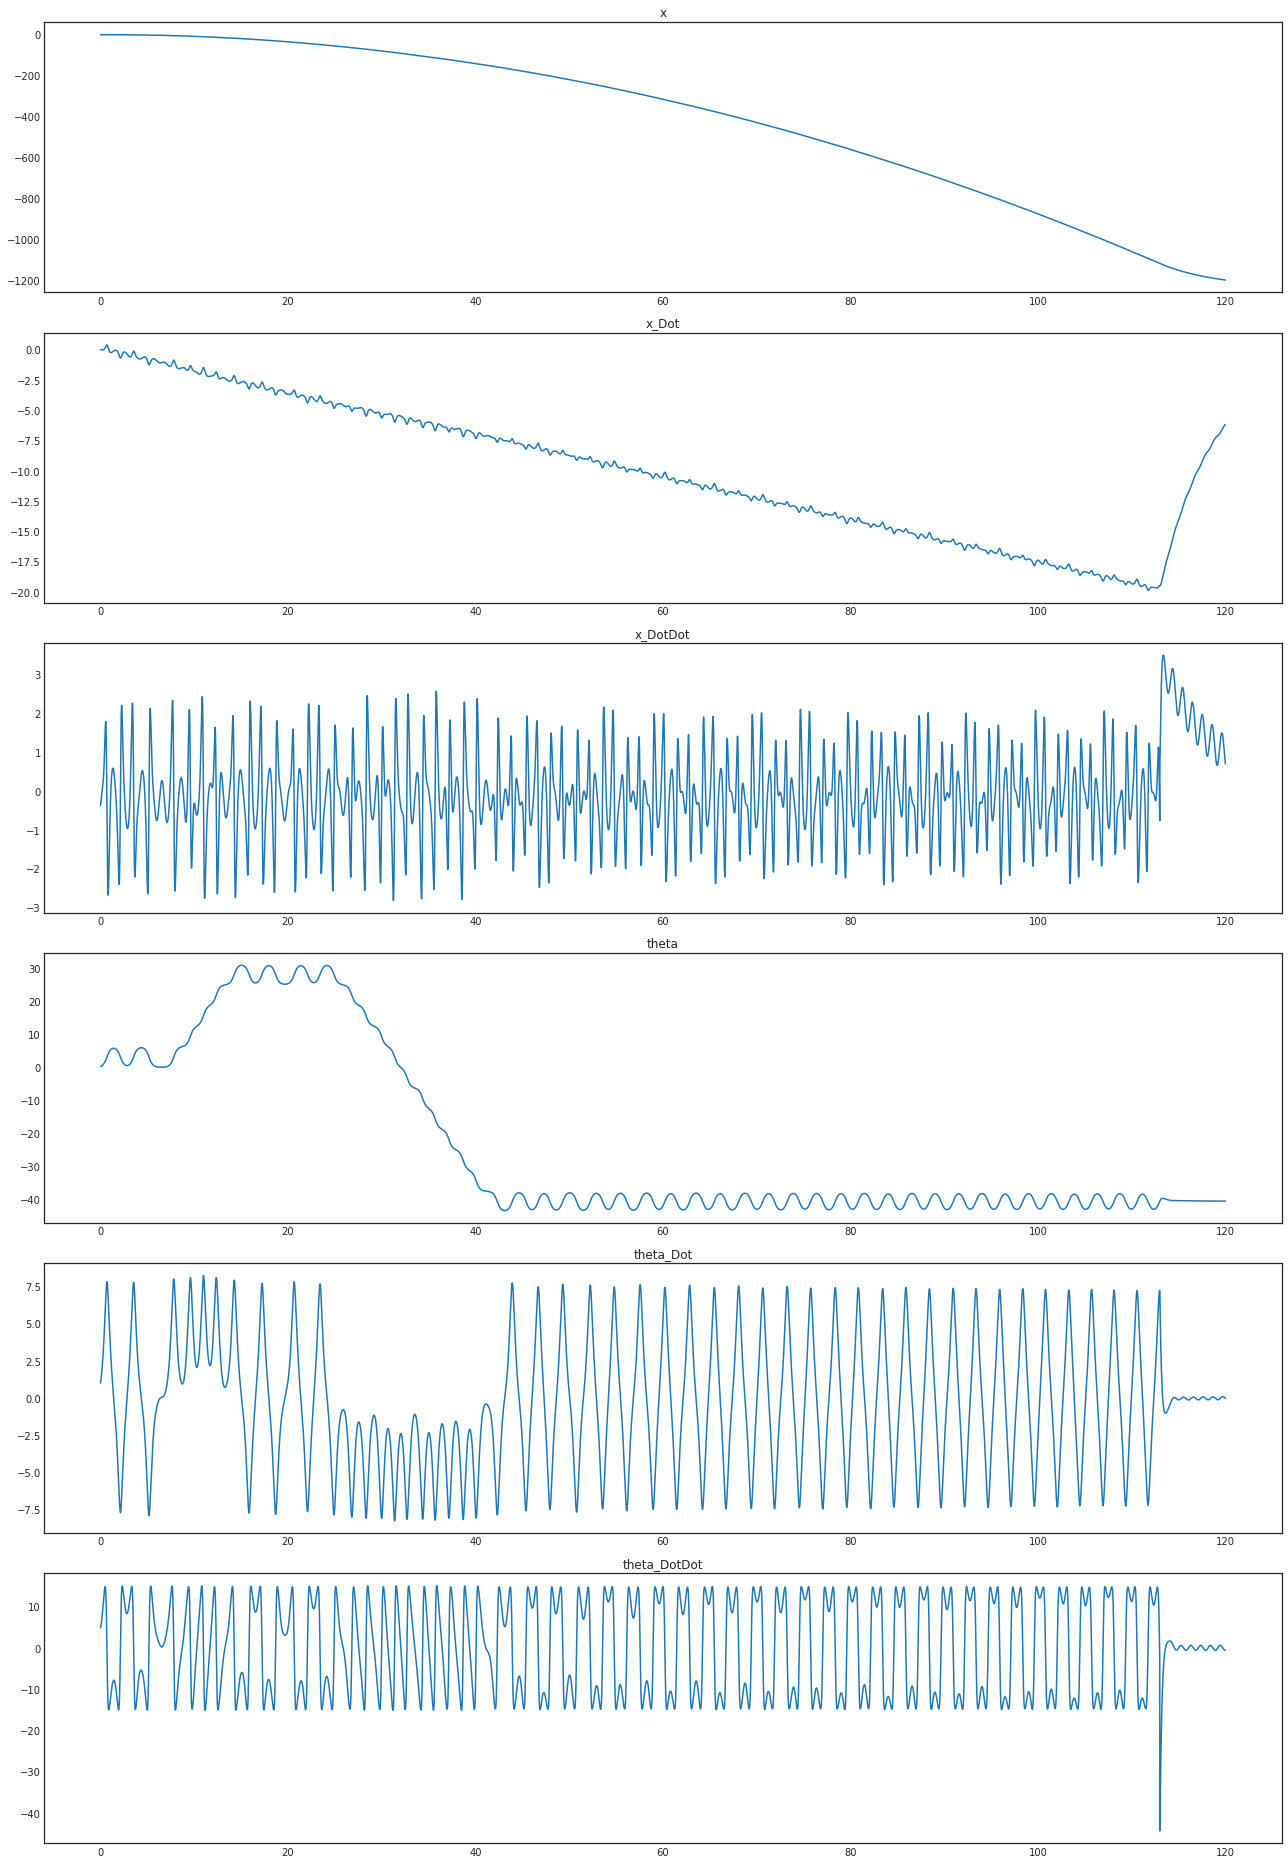

In [27]:
# Converting to Numpy Arrays for Plotting
theta_dd_sim = np.array(theta_dd_sim)
theta_d_sim = np.array(theta_d_sim)
theta_sim = np.array(theta_sim)
x_dd_sim = np.array(x_dd_sim)
x_d_sim = np.array(x_d_sim)
x_sim = np.array(x_sim)

timeSteps = np.linspace(0, noOfSteps/(1/dt), num=noOfSteps, endpoint=False)

startTraj = 0
endTraj = 12000

# Plotting 
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6)

fig.set_figheight(26)
fig.set_figwidth(18)

ax1.plot(timeSteps[startTraj:endTraj], x_sim[startTraj:endTraj])
ax1.set_title("x")
ax2.plot(timeSteps[startTraj:endTraj], x_d_sim[startTraj:endTraj])
ax2.set_title("x_Dot")
ax3.plot(timeSteps[startTraj:endTraj], x_dd_sim[startTraj:endTraj])
ax3.set_title("x_DotDot")
#axs[1, 0].sharex(axs[0, 0])
ax4.plot(timeSteps[startTraj:endTraj], theta_sim[startTraj:endTraj])
ax4.set_title("theta")
ax5.plot(timeSteps[startTraj:endTraj], theta_d_sim[startTraj:endTraj])
ax5.set_title("theta_Dot")
ax6.plot(timeSteps[startTraj:endTraj], theta_dd_sim[startTraj:endTraj])
ax6.set_title("theta_DotDot")
fig.tight_layout()

Text(0.5, 1.0, 'A single plot')

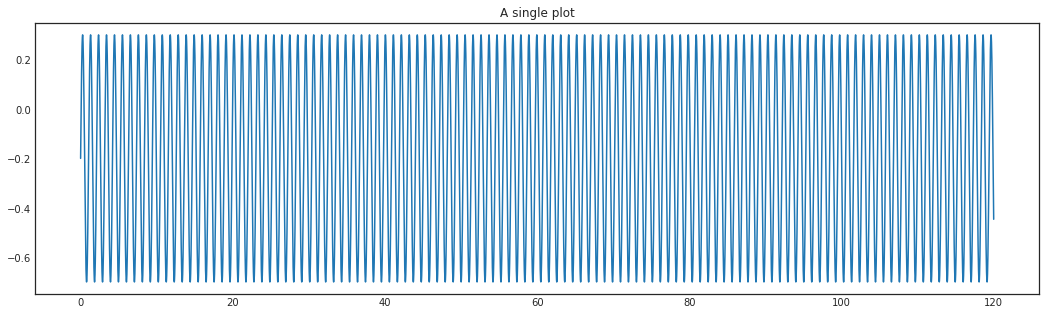

In [28]:
# Force Input Plot 
forceIn = -0.2+0.5*np.sin(6*timeSteps)
fig, ax = plt.subplots()

fig.set_figheight(5)
fig.set_figwidth(18)

ax.plot(timeSteps[startTraj:endTraj], forceIn[startTraj:endTraj])
ax.set_title('A single plot')

# Training 

In [17]:
st_Traj = 0
en_Traj = 8000 # 2307 # 9405

# Training Input (Standardized)
theta_sim_mean = theta_sim[st_Traj:en_Traj].mean()
theta_sim_stdev = theta_sim[st_Traj:en_Traj].std()

theta_d_sim_mean = theta_d_sim[st_Traj:en_Traj].mean()
theta_d_sim_stdev = theta_d_sim[st_Traj:en_Traj].std()

x_d_sim_mean = x_d_sim[st_Traj:en_Traj].mean()
x_d_sim_stdev = x_d_sim[st_Traj:en_Traj].std()

forceIn_mean = forceIn[st_Traj:en_Traj].mean()
forceIn_stdev = forceIn[st_Traj:en_Traj].std()  

# Training Output (Standardized)
theta_dd_sim_mean = theta_dd_sim[st_Traj:en_Traj].mean()
theta_dd_sim_stdev = theta_dd_sim[st_Traj:en_Traj].std()  

x_dd_sim_mean = x_dd_sim[st_Traj:en_Traj].mean()
x_dd_sim_stdev = x_dd_sim[st_Traj:en_Traj].std() 

X_train = np.stack(((theta_sim[st_Traj:en_Traj]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[st_Traj:en_Traj]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[st_Traj:en_Traj]-x_d_sim_mean)/x_d_sim_stdev,(forceIn[st_Traj:en_Traj]-forceIn_mean)/forceIn_stdev), axis=1)

Y_train_theta = ((theta_dd_sim[st_Traj:en_Traj]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_train_x = ((x_dd_sim[st_Traj:en_Traj]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

# Testing Output (Standardized)

Y_test_theta = ((theta_dd_sim[en_Traj:]-theta_dd_sim_mean)/theta_dd_sim_stdev).reshape(-1,1)  # RMSE(A)
Y_test_x = ((x_dd_sim[en_Traj:]-x_dd_sim_mean)/x_dd_sim_stdev).reshape(-1,1)  # RMSE(V)

X_prior = np.stack(((theta_sim[:-1]-theta_sim_mean)/theta_sim_stdev,(theta_d_sim[:-1]-theta_d_sim_mean)/theta_d_sim_stdev,(x_d_sim[:-1]-x_d_sim_mean)/x_d_sim_stdev,(forceIn-forceIn_mean)/forceIn_stdev), axis=1) # Prior


In [21]:
def train_out(Y_train):    
    noise = 0.017

    #k1 = GPy.kern.ExpQuad(input_dim=3)
    #k2 = GPy.kern.Exponential(input_dim=3)

    #myKernel = k1*k2
    myKernel = GPy.kern.RatQuad(input_dim=4, ARD=True)
    gpr = GPy.models.GPRegression(X_train, Y_train, kernel=myKernel)

    # Fix the noise variance to known value 
    gpr.Gaussian_noise.variance = noise**2
    gpr.Gaussian_noise.variance.fix()

    # Run optimization
    gpr.optimize()

    # Display optimized parameter values
    display(gpr)
    return gpr

In [ ]:
gpr_th = train_out(Y_train_theta)

In [ ]:
gpr_x = train_out(Y_train_x)

# saving data

In [29]:
allData = np.stack((theta_sim[:-1], theta_d_sim[:-1], x_sim[:-1], x_d_sim[:-1], forceIn, theta_dd_sim, x_dd_sim), axis=1)
np.savetxt('../noisyCase/noisyData.csv', allData, delimiter=',')

# Just some random testing 

# Truncated Gaussian 

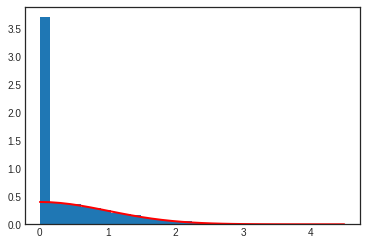

In [80]:
mu, sigma = 0.000002, 1  
rand_mu1 = np.fmax(0, np.random.normal(mu, sigma, 12000))
count, bins, ignored = plt.hist(rand_mu1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

# Log-normal

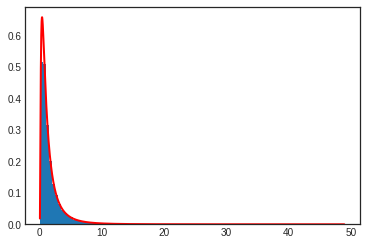

In [81]:
mu, sigma = 0.000002, 1  
rand_mu2 = np.random.lognormal(mu, sigma, 12000)
count, bins, ignored = plt.hist(rand_mu2, 100, density=True, align='mid')
x = np.linspace(min(bins), max(bins), 10000)
pdf = (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))
plt.plot(x, pdf, linewidth=2, color='r')
plt.axis('tight')
plt.show()

# Uniform 

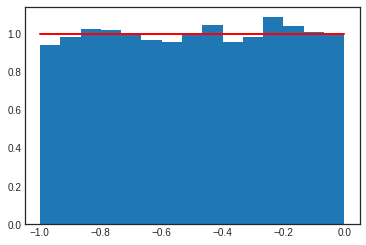

In [30]:
s = np.random.uniform(-1,0,12000)
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()